In [1]:
import torch
import torch.nn
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid
from sklearn_pandas import DataFrameMapper 

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter

from sksurv.ensemble import RandomSurvivalForest

from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

import torchtuples as tt

from auton_survival.models.dsm import DeepSurvivalMachines

from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [2]:
# # Import Data
# flchain = pd.read_csv("resources/other_data/FLCHAIN.csv")
# nwtco = pd.read_csv("resources/other_data/NWTCO.csv")
# whas = pd.read_excel("resources/other_data/whas.xlsx")
# gbsg = pd.read_csv("resources/other_data/gbsg.csv")
# metabric = pd.read_csv("resources/other_data/METABRIC_RNA_Mutation.csv" , low_memory = False)

In [3]:
def train_test_splitter(df , test_size = 0.2 , val_size = 0.2 , duration_col = 'futime' , event_col = 'death'):
    df_test = df.sample(frac=test_size)
    df_train = df.drop(df_test.index)

    df_val = df_train.sample(frac=val_size)
    df_train = df_train.drop(df_val.index)

    return df_train , df_val , df_test

--------------------
## **METABRIC**

In [4]:
df = metabric.read_df()
df_train , df_test , df_val = train_test_splitter(df)

cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train_dur , y_train_event = get_target(df_train)
y_test_dur , y_test_event = get_target(df_test)
y_val_dur , y_val_event = get_target(df_val)

#### **Non-Param**

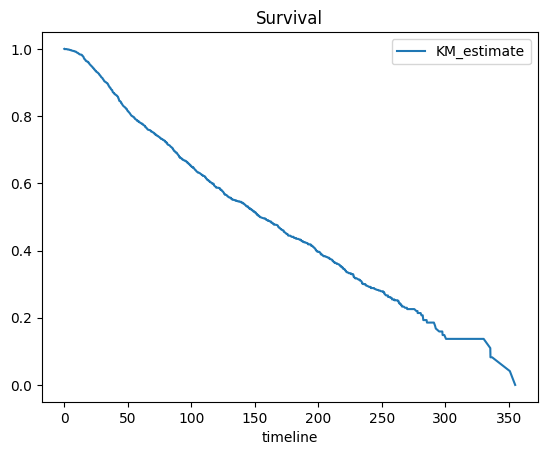

In [5]:
kmf = KaplanMeierFitter()

T = df['duration']
E = df["event"]

kmf.fit(T, event_observed=E)

kmf.survival_function_.plot()
plt.title('Survival');

<Axes: xlabel='timeline'>

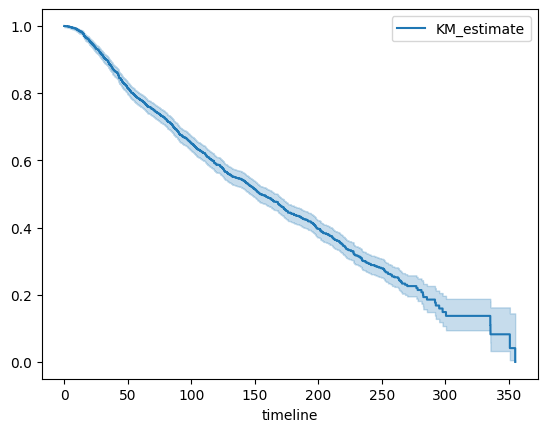

In [6]:
kmf.plot_survival_function()

<Axes: xlabel='timeline'>

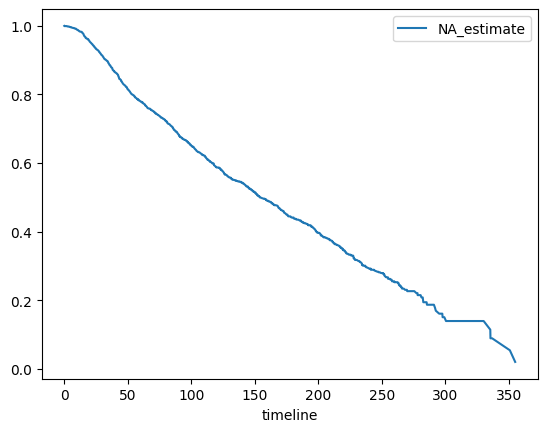

In [7]:
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)
# print(naf.cumulative_hazard_.head())
# naf.plot_cumulative_hazard()
np.exp(-naf.cumulative_hazard_).plot()
# naf.plot_survival_function()

#### **Semi-Param**

In [8]:
X_train = pd.DataFrame(np.column_stack([x_train , y_train_dur , y_train_event]))

cph = CoxPHFitter()
cph.fit(X_train, duration_col=9, event_col=10)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1218 total observations, 507 right-censored observations>
             duration col = '9'
                event col = '10'
      baseline estimation = breslow
   number of observations = 1218
number of events observed = 711
   partial log-likelihood = -4458.07
         time fit was run = 2023-07-08 17:01:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
0           0.03       1.03       0.04            -0.06             0.11                 0.94                 1.12
1          -0.09       0.91       0.04            -0.18            -0.00                 0.84                 1.00
2           0.12       1.13       0.04             0.04             0.20                 1.04                 1.22
3           0.07       1.07       0.04            -0.01             0.14                 0.99                 1.15
4           0.56       1.75       0.05             0.47             0.66                 1.59                 1.93
5           0.15       1.16       0.09            -0.02             0.32                 0.98                 1.37
6          -0.25       0.78       0.08            -0.40            -0.10                 0.67                 0.91
7           0.73       2.08       0.13             0.48             0.98                 1.62                 2.67
8           0.04       1.05       0.13            -0.21             0.30                 0.81                 1.35

            cmp to     z      p   -log2(p)
covariate                                 
0             0.00  0.57   0.57       0.82
1             0.00 -2.04   0.04       4.61
2             0.00  3.06 <0.005       8.84
3             0.00  1.64   0.10       3.31
4             0.00 11.44 <0.005      98.33
5             0.00  1.73   0.08       3.59
6             0.00 -3.17 <0.005       9.38
7             0.00  5.74 <0.005      26.66
8             0.00  0.35   0.73       0.46
---
Concordance = 0.63
Partial AIC = 8934.14
log-likelihood ratio test = 189.39 on 9 df
-log2(p) of ll-ratio test = 117.12

<Axes: >

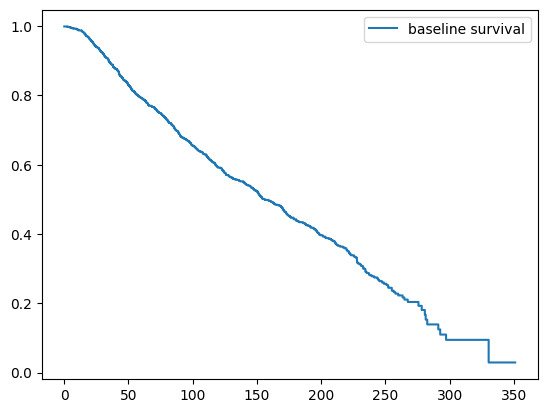

In [9]:
cph.baseline_survival_.plot(drawstyle = 'steps')
# cph_strat.baseline_cumulative_hazard_.plot(drawstyle="steps")

#### **Param**

In [10]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter()
eps = 1e-8
X_train[9] = X_train[9] + eps

aft.fit(X_train, duration_col=9, event_col=10)

aft.print_summary(3)  # access the results using aft.summary

<lifelines.WeibullAFTFitter: fitted with 1218 total observations, 507 right-censored observations>
             duration col = '9'
                event col = '10'
   number of observations = 1218
number of events observed = 711
           log-likelihood = -4393.861
         time fit was run = 2023-07-08 17:01:44 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                         
lambda_ 0         -0.017      0.983      0.033           -0.083            0.048                0.921                1.049
        1          0.065      1.067      0.033            0.000            0.130                1.000                1.138
        2         -0.094      0.910      0.029           -0.152           -0.036                0.859                0.964
        3         -0.052      0.949      0.030           -0.111            0.007                0.895                1.007
        4         -0.423      0.655      0.037           -0.495           -0.351                0.610                0.704
        5         -0.097      0.908      0.063           -0.221            0.027                0.802                1.028
        6          0.189      1.208      0.059            0.073            0.305                1.076                1.357
        7         -0.565      0.568      0.095           -0.753           -0.378                0.471                0.685
        8         -0.045      0.956      0.096           -0.234            0.144                0.791                1.155
        Intercept  5.395    220.195      0.091            5.217            5.572              184.393              262.947
rho_    Intercept  0.288      1.334      0.032            0.226            0.350                1.254                1.419

                    cmp to       z       p   -log2(p)
param   covariate                                    
lambda_ 0            0.000  -0.521   0.603      0.731
        1            0.000   1.967   0.049      4.346
        2            0.000  -3.203   0.001      9.521
        3            0.000  -1.735   0.083      3.595
        4            0.000 -11.476 <0.0005     98.861
        5            0.000  -1.531   0.126      2.991
        6            0.000   3.195   0.001      9.482
        7            0.000  -5.921 <0.0005     28.218
        8            0.000  -0.468   0.640      0.644
        Intercept    0.000  59.586 <0.0005        inf
rho_    Intercept    0.000   9.144 <0.0005     63.850
---
Concordance = 0.634
AIC = 8809.722
log-likelihood ratio test = 192.867 on 9 df
-log2(p) of ll-ratio test = 119.541

<Axes: >

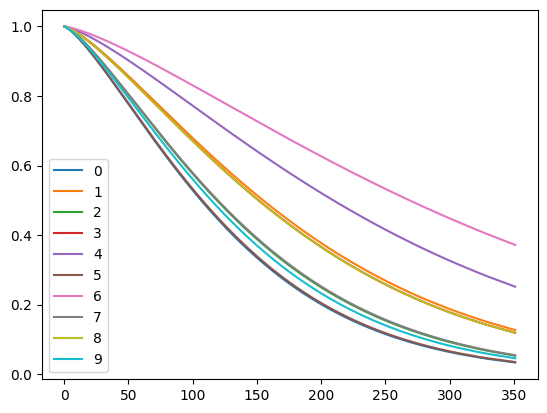

In [11]:
X_test = pd.DataFrame(np.column_stack([x_test , y_test_dur , y_test_event]))

aft.predict_survival_function(X_test.iloc[:10]).plot()

#### **Random Survival Forest**

In [12]:
y_train = np.rec.array([y_train_event.astype('bool') , y_train_dur])
y_test = np.rec.array([y_test_event.astype('bool') , y_test_dur])
y_val = np.rec.array([y_val_event.astype('bool') , y_val_dur])

X_val = pd.DataFrame(np.column_stack([x_val , y_val_dur , y_val_event]))

In [13]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=1234
)
rsf.fit(X_train.iloc[: , :-2], y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=1234)

In [14]:
# Concordance
rsf.score(X_test.iloc[: , :-2], y_test)  , rsf.score(X_val.iloc[: , :-2], y_val) 

(0.6329809472615421, 0.6583094555873925)

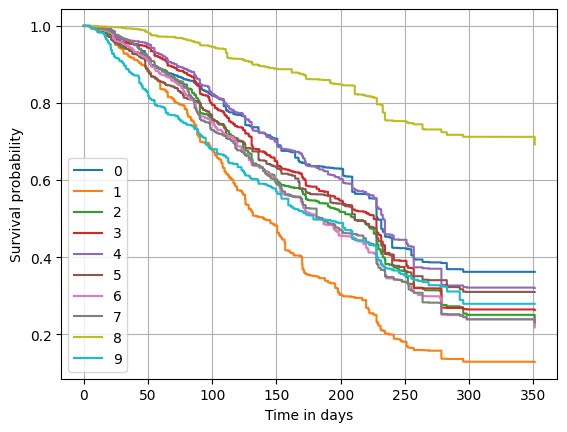

In [15]:
surv = rsf.predict_survival_function(X_val.iloc[: , :-2][:10], return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

#### **PyCox**

In [16]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [17]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 3.0015,	val_loss: 2.9852
1:	[0s / 0s],		train_loss: 2.6812,	val_loss: 2.6942
2:	[0s / 0s],		train_loss: 2.4194,	val_loss: 2.3425
3:	[0s / 0s],		train_loss: 2.0851,	val_loss: 1.9373
4:	[0s / 0s],		train_loss: 1.7452,	val_loss: 1.6165
5:	[0s / 0s],		train_loss: 1.5218,	val_loss: 1.4438
6:	[0s / 0s],		train_loss: 1.4259,	val_loss: 1.3878
7:	[0s / 0s],		train_loss: 1.3925,	val_loss: 1.3696
8:	[0s / 0s],		train_loss: 1.3770,	val_loss: 1.3639
9:	[0s / 0s],		train_loss: 1.3402,	val_loss: 1.3642
10:	[0s / 0s],		train_loss: 1.3273,	val_loss: 1.3727
11:	[0s / 0s],		train_loss: 1.3256,	val_loss: 1.3780
12:	[0s / 0s],		train_loss: 1.3002,	val_loss: 1.3778
13:	[0s / 0s],		train_loss: 1.3068,	val_loss: 1.3732
14:	[0s / 0s],		train_loss: 1.2932,	val_loss: 1.3658
15:	[0s / 0s],		train_loss: 1.2874,	val_loss: 1.3670
16:	[0s / 0s],		train_loss: 1.2826,	val_loss: 1.3706
17:	[0s / 0s],		train_loss: 1.2779,	val_loss: 1.3759
18:	[0s / 0s],		train_loss: 1.2652,	val_loss: 1.3743


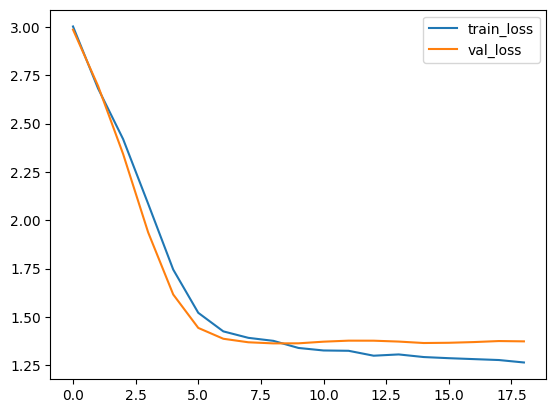

In [18]:
_ = log.plot()

surv = model.predict_surv_df(x_test)

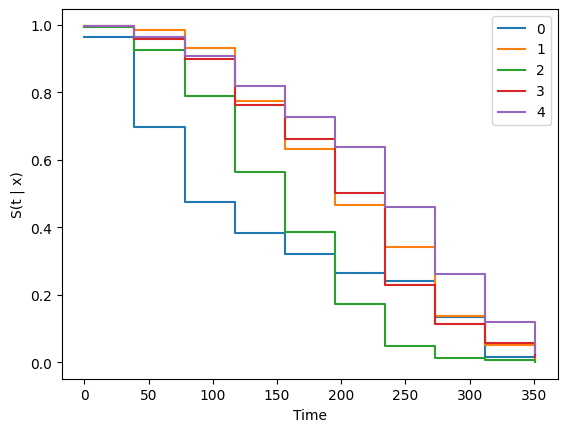

In [19]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

shapes : (305, 305, 305, 305)
td-concordance 0.6126142268410679
integrated brier score 0.17341621311324967


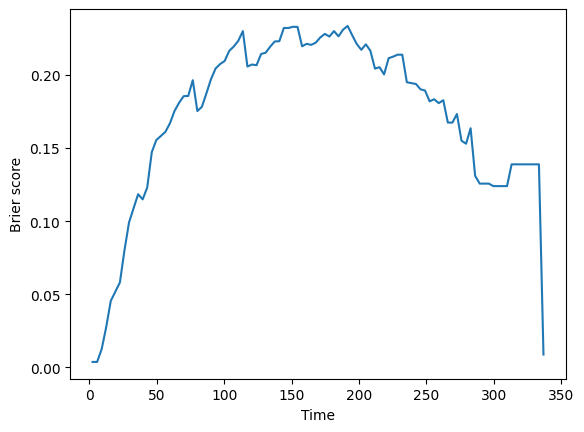

In [20]:
from eval_surv_copy import EvalSurv
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **DSM**

In [21]:
import numpy as np
horizons = np.linspace(0,1,11)
times = np.quantile(y_train[0][y_train[1]==1], horizons).tolist()

In [22]:
x_train, x_test, x_val = X_train.iloc[: , :-2], X_test.iloc[: , :-2], X_val.iloc[: , :-2]
t_train, t_test, t_val = y_train[0] , y_test[0] , y_val[0]
e_train, e_test, e_val = y_train[1] , y_test[1] , y_val[1]

In [23]:
param_grid = {'k' : [3,],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [ 1e-4, 1e-3],
              'layers' : [ [100], [100, 100] ]
             }
params = ParameterGrid(param_grid)

In [24]:
models = []
for param in params:
    model = DeepSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 layers = param['layers'])
    # The fit method is called to train the model
    model.fit(x_train.to_numpy(), t_train, e_train, iters = 100, learning_rate = param['learning_rate'])
    models.append([[model.compute_nll(x_val.to_numpy(), t_val, e_val), model]])
best_model = min(models)
model = best_model[0][1]

100%|██████████| 100/100 [00:02<00:00, 34.98it/s]


In [26]:
out_risk = model.predict_risk(x_test.to_numpy(), times)
out_survival = model.predict_survival(x_test.to_numpy(), times)

out_risk

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [27]:
x_train.to_numpy().shape, t_train.shape, e_train.shape

((1218, 9), (1218,), (1218,))

In [29]:
type(x_train.to_numpy()), type(t_train), type(e_train)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [34]:
np.linalg.matrix_rank(np.cov(x_train.to_numpy()))

8